# Which variables are good at predicting whether or not someone has heart disease?


## Introduction

Heart disease is prevalent among many individuals, particularly the elderly. Conory artery disease, a subset of heart disease, will be the focus of this investigation. This condition can obstruct blood flow to the heart and lead to the weakening of cardiac muscles. Often, it goes unnoticed until severe symptoms manifest, such as a heart attack. Identifying warning signs of coronary artery disease in seniors is crucial to ensure timely treatment. Yet, detecting it without reliable diagnostic variables poses challenges. In this exploration, various variables will undergo testing to gauge their efficacy in predicting heart disease. The central enquiry will revolve around determining which variables demonstrate strong predictive capabilities. This insight can help inform diagnososes, with emphasis placed on variables deemed effective predictors. The dataset utilized for this exploration originates from UCI, focusing on Swiss and Hungarian data.

In [2]:
library(tidyverse)
library(readr)
library(dplyr)
library(stringr)
library(tidymodels)
library(yardstick)
library(ggplot2)

# Method and Results

We begin by loading and wrangling the data from the UCI database.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
file_path <- "cleve.mod"
download.file(url, destfile = file_path)
heart_data <- read_table(file_path, skip = 20, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                                                    "thalach", "exang", "oldpeak", "slope", "ca", "thal", 
                                                                    "disease"), na = "?")

heart_data$disease <- str_replace_all(string = heart_data$disease, pattern = "buff", replacement = "healthy")

heart_data<-heart_data|>
            mutate(disease = as_factor(disease))
head(heart_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  age = col_double(),
  sex = col_character(),
  cp = col_character(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  thalach = col_double(),
  exang = col_character(),
  oldpeak = col_double(),
  slope = col_character(),
  ca = col_double(),
  thal = col_character(),
  disease = col_character()
)

Warning message:
“303 parsing failures.
row col   expected     actual        file
  1  -- 14 columns 15 columns 'cleve.mod'
  2  -- 14 columns 15 columns 'cleve.mod'
  3  -- 14 columns 15 columns 'cleve.mod'
  4  -- 14 columns 15 columns 'cleve.mod'
  5  -- 14 columns 15 columns 'cleve.mod'
... ... .......... .......... ...........
See problems(...) for more details.
”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick
37,male,notang,130,250,fal,norm,187,fal,3.5,down,0,norm,healthy
41,fem,abnang,130,204,fal,hyp,172,fal,1.4,up,0,norm,healthy
56,male,abnang,120,236,fal,norm,178,fal,0.8,up,0,norm,healthy


Above: Imported coronary artery disease data as a tibble

Next, we reproducibly split the data into training and testing sets.

In [4]:
set.seed(8888)
# split data into training and testing data
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Here, we enumerate the missing entries. As can be seen by the output, 5 rows have missing data.

In [5]:
#locate missing data (training data)
train_missing_column <- colSums(is.na(heart_train))
locate_missing_train <- which(!complete.cases(heart_train))
sum_missing_train <- sum(is.na(heart_train))


cat("\033[1mNumber of Missing Data in Each Column: \n")
train_missing_column
cat("\033[1mLocation of Rows That Have Missing Data: \033[0m", locate_missing_train, "\n")
cat("\033[1mNumber of Rows That have Missing Data: \033[0m", sum_missing_train)

Number of Missing Data in Each Column: 


age      sex       cp trestbps     chol      fbs  restecg  thalach 
       0        0        0        0        0        0        0        0 
   exang  oldpeak    slope       ca     thal  disease 
       0        0        0        3        2        0

Location of Rows That Have Missing Data:  34 56 101 181 192 
Number of Rows That have Missing Data:  5

We now determine the proportions of sick to healthy individuals in the dataset.

In [6]:
# Frequency of Each Class
cat("\033[1mTable 1: Frequency of Each Group of People\n")
table(heart_data$disease)

#Proportion of Each Class
cat("\033[1mTable 2: Proportion of Each Group of People\n")
prop.table(table(heart_data$disease))

Table 1: Frequency of Each Group of People



healthy    sick 
    165     138 

Table 2: Proportion of Each Group of People



  healthy      sick 
0.5445545 0.4554455 

We now attempt to determine good predictors by seeing if there is a significant difference in the prevalence of a classification by comparing sick and healthy groups using boxplots.

 For the plots below: The box-plot medians are far apart. Therefore, the maximum heart rate achieved
and ST depression induced by exercise relative to rest 
are likely statistically significant in determining heart disease. 
 
Plot 1: Maximum Heart Rate Achieved Comparison


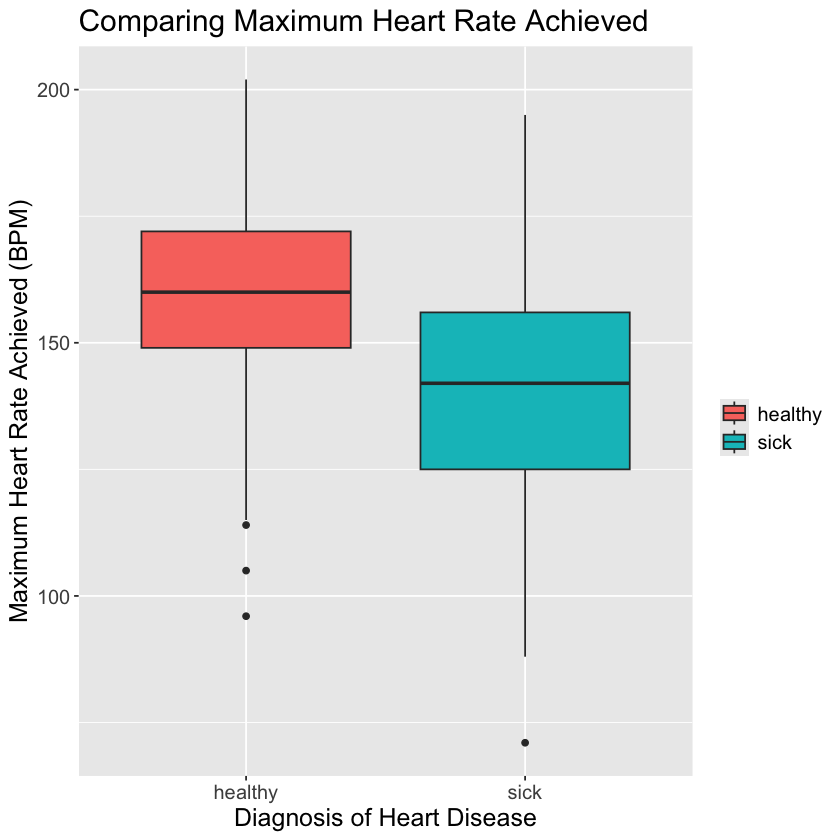

Plot 2: ST Depression Induced by Exercise Relative to Rest Comparison

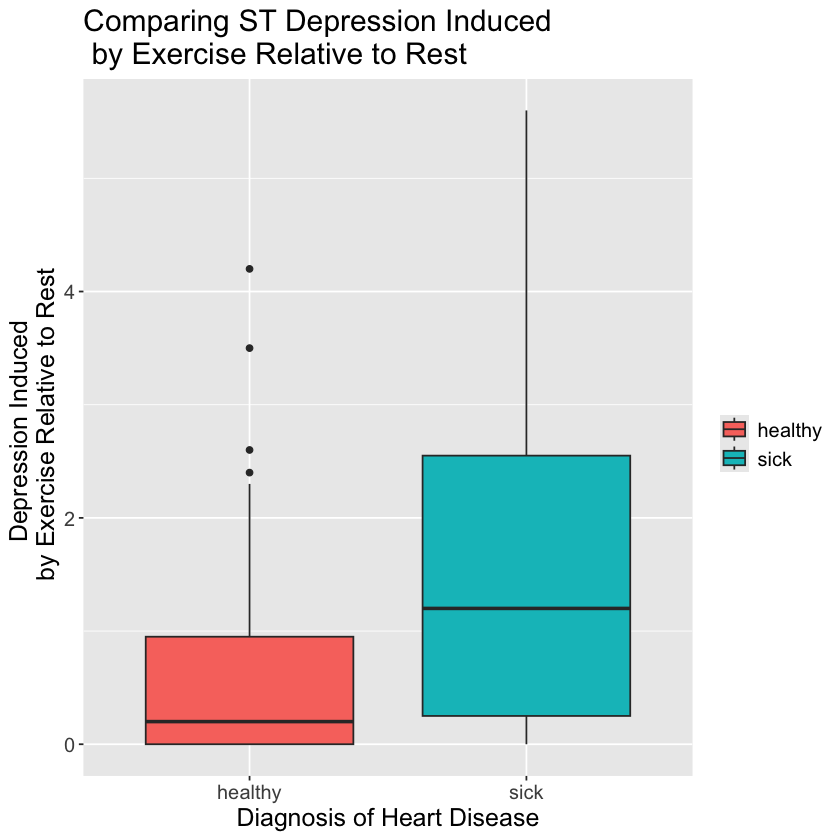

For the plots below: The box-plots medians nearly overlap. Therefore, serum cholestoral level 
 and resting blood pressure are likely not statistically significant in determining heart disease.
 and will not be used furthermore in this report.

Plot 3: Serum Cholesterol Level Comparison 

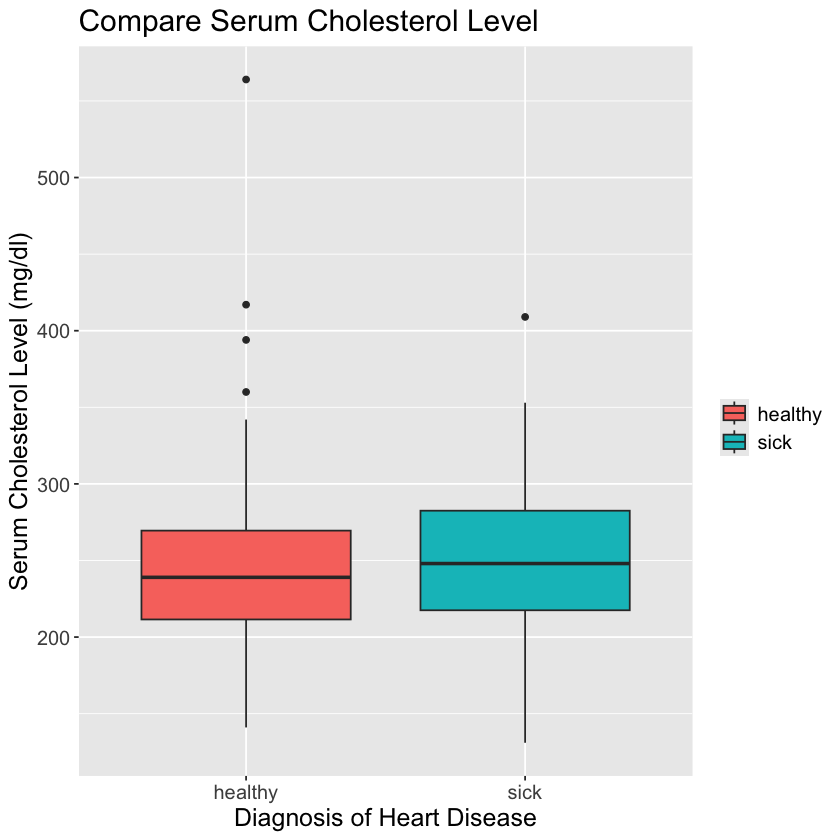

Plot 4: Resting Blood Pressure Comparison

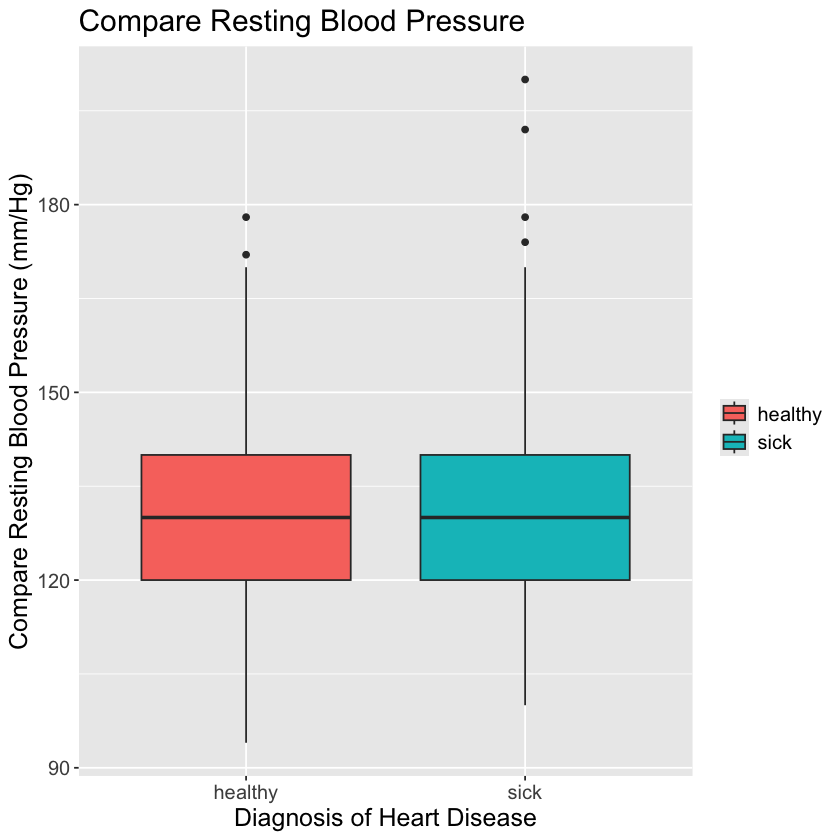

In [7]:
# Visualization (boxplots)
#Compare Maximum Heart Rate Achieved between sick or not
cat("\033[1m For the plots below: The box-plot medians are far apart. Therefore, the maximum heart rate achieved\nand ST depression induced by exercise relative to rest \nare likely statistically significant in determining heart disease. \n ")

cat("\033[1m\nPlot 1: Maximum Heart Rate Achieved Comparison\n")
thalach_boxplot <- heart_train |>
  ggplot(aes(x = disease, y = thalach, group = disease)) +
  geom_boxplot(aes(fill = disease)) +
  labs(title = "Comparing Maximum Heart Rate Achieved",
       x = "Diagnosis of Heart Disease", 
       y = "Maximum Heart Rate Achieved (BPM)",
       fill = " ") +
       theme(text = element_text(size = 15)) 
thalach_boxplot


#compare ST depression induced by exercise relative to rest between sick or not

oldpeak_boxplot <- heart_train |>
  ggplot(aes(x = disease, y = oldpeak, group = disease)) +
  geom_boxplot(aes(fill = disease)) +
  labs(title = "Comparing ST Depression Induced \n by Exercise Relative to Rest",
       x = "Diagnosis of Heart Disease",
       y = "Depression Induced \n by Exercise Relative to Rest",
       fill = " ") +
       theme(text = element_text(size = 15))
oldpeak_boxplot

cat("\033[1mPlot 2: ST Depression Induced by Exercise Relative to Rest Comparison")

#compare serum cholestorol level between sick or not
chol_boxplot <- heart_train |>
  ggplot(aes(x = disease, y = chol, group = disease)) +
  geom_boxplot(aes(fill = disease)) +
  labs(title = "Compare Serum Cholesterol Level",
       x = "Diagnosis of Heart Disease",
       y = "Serum Cholesterol Level (mg/dl)",
       fill = " ") +
       theme(text = element_text(size = 15))
chol_boxplot

cat("\033[1mFor the plots below: The box-plots medians nearly overlap. Therefore, serum cholestoral level \n and resting blood pressure are likely not statistically significant in determining heart disease.\n and will not be used furthermore in this report.\n")
cat("\033[1m\nPlot 3: Serum Cholesterol Level Comparison ")

#compare Resting Blood Pressure between sick or not
trestbps_boxplot <- heart_train |> 
  ggplot(aes(x = disease, y = trestbps, group = disease)) +
  geom_boxplot(aes(fill = disease)) +
  labs(title = "Compare Resting Blood Pressure",
       x = "Diagnosis of Heart Disease",
       y = "Compare Resting Blood Pressure (mm/Hg)",
       fill = " ") +
       theme(text = element_text(size = 15))
trestbps_boxplot

cat("\033[1mPlot 4: Resting Blood Pressure Comparison")

We build and tune a K-nearest neighbors classification model to predict disease outcomes based on the predictor variables of thalach (maximum heartrate) and oldpeak (ST depression caused by exercise). Beginning with data preprocessing, the predictors are standardized and centered to ensure consistency and interpretability. Subsequently, the k-nearest neighbours algorithm is configured with a rectangular weight function, and the optimal number of neighbors is determined through a grid search using v-fold cross-validation. This cross-validation strategy partitions the training data into five folds, maintaining stratification based on disease status to ensure robust evaluation. By iteratively training and evaluating the model on different subsets of the data, cross-validation provides an accurate estimate of the model's performance, measured by accuracy — the proportion of correctly classified instances.

In [ ]:
set.seed(168)
heart_recipe <- recipe(disease ~ thalach + oldpeak, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)
heart_k <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_tune) |>
  tune_grid(resamples = heart_vfold, grid = 10) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))
head(heart_k)

also installing the dependency ‘igraph’





The downloaded binary packages are in
	/var/folders/5y/f2gxs3rd1px9742dhtwbjbc40000gn/T//RtmpZZgzR7/downloaded_packages


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7339921,5,0.02866873,Preprocessor1_Model07
10,accuracy,binary,0.7339921,5,0.02866873,Preprocessor1_Model08
12,accuracy,binary,0.7203557,5,0.02106389,Preprocessor1_Model09
14,accuracy,binary,0.7162055,5,0.01577132,Preprocessor1_Model10
7,accuracy,binary,0.6897233,5,0.02444329,Preprocessor1_Model06
4,accuracy,binary,0.6632411,5,0.01941241,Preprocessor1_Model03


We test various K values to determine the one with the highest accuracy via iterating them. We pick the K value with the highest accuracy for our model.

Plot 5: Accuracy vs. K

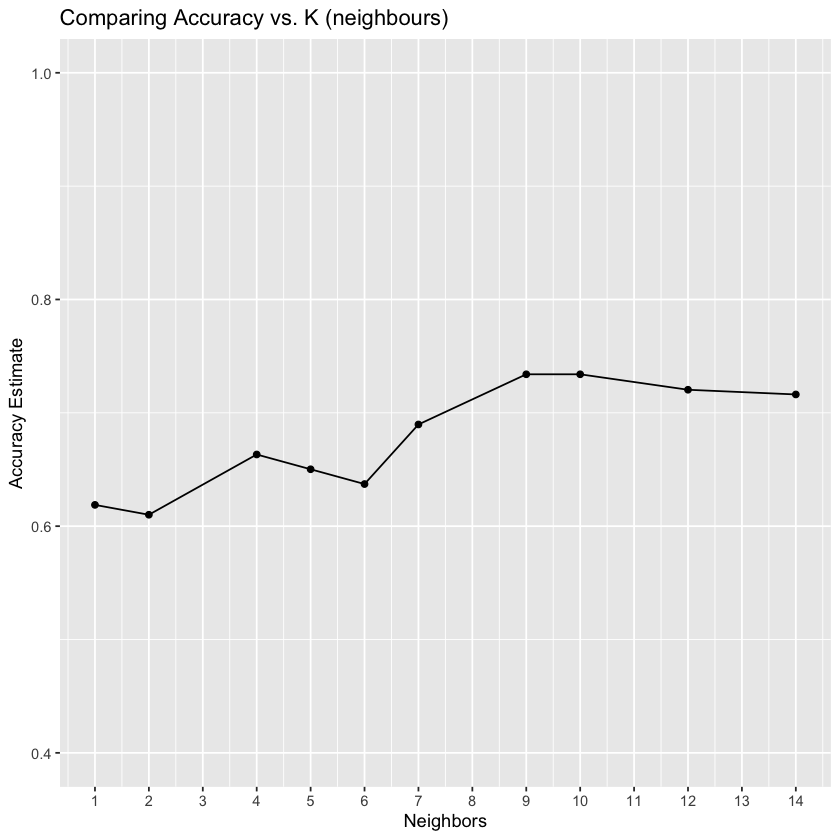

In [10]:
accuracies <- heart_k |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Comparing Accuracy vs. K (neighbours)") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

cat("\033[1mPlot 5: Accuracy vs. K")

We apply our model to predict the test set, which will give us a measure of the model's performance.

In [11]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_spec) |>
  fit(data = heart_train)
# predict
heart_predict <- predict(heart_fit, heart_test) |>
  bind_cols(heart_test)
head(heart_predict)

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
sick,67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick
sick,41,fem,abnang,130,204,fal,hyp,172,fal,1.4,up,0,norm,healthy
healthy,57,fem,asympt,120,354,fal,norm,163,true,0.6,up,0,norm,healthy
sick,64,male,angina,110,211,fal,hyp,144,true,1.8,flat,0,norm,healthy
healthy,58,male,abnang,120,284,fal,hyp,160,fal,1.8,flat,0,norm,sick
healthy,43,male,asympt,150,247,fal,norm,171,fal,1.5,up,0,norm,healthy


Above is a dataframe displaying predicted disease outcomes alongside test data, generated by a K-nearest neighbors classification model.

We determine the accuracy of the predictions on the test set, and furthermore display the results as a truth table. The model was approximately 78% accurate.

In [12]:
cat("\033[1mTable 3: Accuracy Estimate\n")
heart_predict <- mutate(heart_predict, disease = as.factor(disease))
heart_accuracy <- heart_predict |>
  metrics(truth = disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")
heart_accuracy


cat("\033[1mTable 4: Confusion Matrix\n")
heart_mat <- heart_predict |>
  conf_mat(truth = disease, estimate = .pred_class)
heart_mat




Table 3: Accuracy Estimate


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7662338


Table 4: Confusion Matrix


          Truth
Prediction healthy sick
   healthy      34   10
   sick          8   25

Above: Truth table showing the accuracy of our model.

We establish a grid comprising thalach (maximum heart rate achieved during exercise) and oldpeak (ST depression induced by exercise relative to rest) values, systematically arranging them into a structured data frame. Subsequently, utilizing a pre-established workflow, we forecast disease outcomes for each point within this grid. These prognostications are then integrated with the respective grid points, resulting in a comprehensive tabular representation wherein disease predictions are clearly delineated. This tabulated output serves as a valuable resource for discerning how our model predicts disease across varying combinations of thalach and oldpeak values.

In [13]:
# Create the grid of thalach/oldpeak values, and arrange in a data frame
thalach_grid <- seq(min(heart_data$thalach, na.rm = TRUE),
                    max(heart_data$thalach, na.rm = TRUE),
                    length.out = 100)
oldpeak_grid <- seq(min(heart_data$oldpeak, na.rm = TRUE),
                    max(heart_data$oldpeak, na.rm = TRUE),
                    length.out = 100)


thalach_oldpeak_grid <- as_tibble(expand.grid(thalach = thalach_grid,
                                              oldpeak = oldpeak_grid))

# Use the fit workflow to make predictions at the grid points
knn_pred_grid <- predict(heart_fit, thalach_oldpeak_grid)

# Bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knn_pred_grid, thalach_oldpeak_grid) |>
  rename(disease = .pred_class) 
head(prediction_table)

disease,thalach,oldpeak
<fct>,<dbl>,<dbl>
sick,71.00000,0
sick,72.32323,0
sick,73.64646,0
sick,74.96970,0
sick,76.29293,0
sick,77.61616,0


We lastly plot the classifier as coloured regions, with the predictor values as axes. Values of maximum heart rate of less than 100 and ST depressions of over 4 seem to correlate with heart disease using this model.

Scatter plot of thalach versus oldpeak where background color indicates the decision of the classifier.


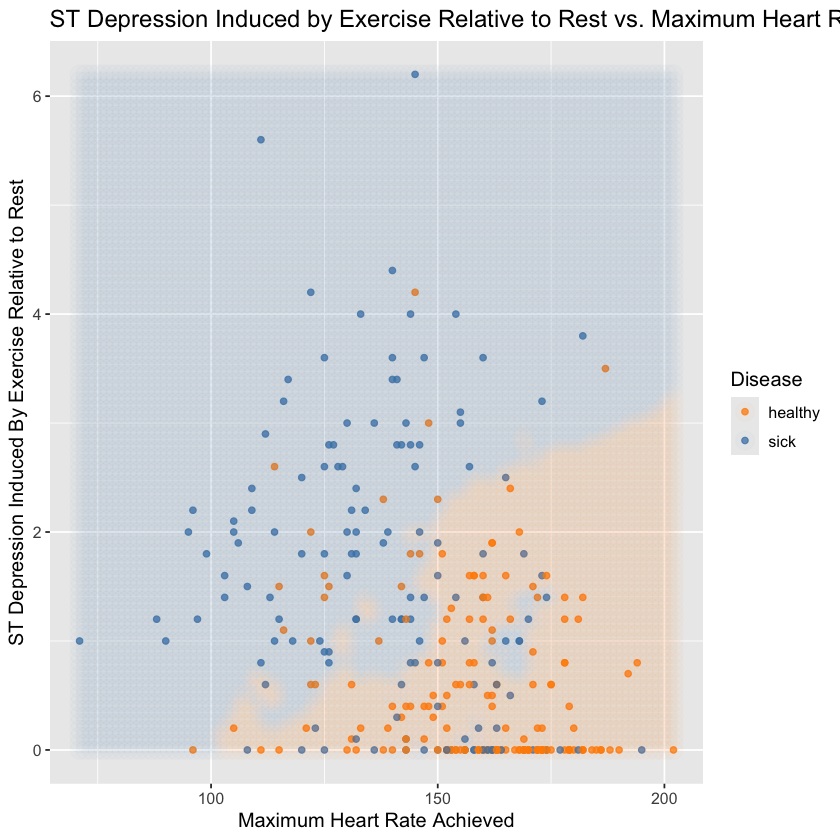

In [14]:
#plot
heart_plot <-
  ggplot() +
  geom_point(data = heart_data,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.02,
             size = 5) +
  labs(color = "Disease",
       x = "Maximum Heart Rate Achieved",
       y = "ST Depression Induced By Exercise Relative to Rest") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  ggtitle("ST Depression Induced by Exercise Relative to Rest vs. Maximum Heart Rate Achieved") +
  theme(text = element_text(size = 12))

heart_plot

cat("\033[1mScatter plot of thalach versus oldpeak where background color indicates the decision of the classifier.\n")


# Discussion

Through revision and reassessment, the variables thalach (one’s maximum heart rate) and oldpeak (ST depression caused by exercise) were selected for further analysis for the project. Various techniques were used, all involving said variables being plotted against proportionality to indicate results. Through KNN classification, our method yields around a 60%-78% accuracy with analysis, and is the highest at a value of 9 neighbors. It is also worthy to note that on the accuracy vs. K graph, there is typically no value of K that has a much higher accuracy compared to other K values, which may imply that the model accuracy will not be outstandingly high regardless of other K values chosen. The classifier can also be seen in greater detail via visualization, seeing that though most points are in their respective regions, there are some points that are not in their intended region, noting the margin of error present in the model. The visualization sees that thalach below around 120 indicates the onset or diagnosis of heart disease, whilst oldpeak indicates heart disease the higher value it reaches, with the highest number of healthy points being concentrated at a level of 0. The regions seen on the graph also indicate the conclusions given above, seeing that the healthy region is in the lower-right of the page, that being the location with high thalach and low oldpeak values respectively. Though the model overall is somewhat satisfactory in predictions, the majority of them are correct in allowing one to predict someone’s heart health based on their maximum heart rate achieved and ST depression induced by physical activity. 

The expectation was for the classifier to be able to utilize variables given to it through analysis and to be able to indicate or be a suggestion towards a heart disease diagnosis. Once visualized and the accuracy is seen, it can be said that the model can be a predictor for heart disease, though it is not high enough to be a fully concrete predictor seeing its accuracy. Moving forward, the variables could be upsampled so that roughly 50% of each class could be in the dataset. The expectations are met however, as the variables chosen are indicators and statistically relevant enough to at least suggest onset or development of heart disease within individuals. The probability given by the variables chosen and using the most advantageous neighbors value can be concluded to have met the prospect of the project, and to confirm what was predicted in the project’s proposal. 
Although stated earlier that the conclusions given by the model are satisfactory and may only be applied as suggestions and slight predictions rather than a clear diagnosis, the findings from this project can have merit in the form of saving work. Once improved or given more adequate predictors, the model can be a way to filter for relevant cases for diagnosis, and to judge a sample and  very loosely se ewhict proportissn have heart disease. This can be used to classify within a certain sample who needs a diagnosis urgently, and how it can warn certain individuals about their health earlier without much work or a checkup from an actual doctor. The main purpose of the classifier can be used to sort data given to it via the two aforementioned variables, and to list out who is at risk or already with heart disease, and to either give the information to a doctor or the person themselves. This would save the doctor time in assessing an individual patient and save the patient money and time to go see a doctor. Though as stated before the model is far from being concrete and accurate, its ability to at least give an indication of heart disease can greatly convenience those who are involved and to allow more resources to be put into actually curing the heart disease. It is also worth noting that such insight of potential variables capable of predicting can lead to further investigations of variables that analyze similar characteristics which could increase the proficiency of this model if they were found. 

A future prospect for the project could be to get the algorithm to be able to sort by urgency for those who do have a chance of being diagnosed with heart disease. If new or more variables are introduced that are also statistically relevant for a more detailed analysis, there could be a way to sort the ones who are deemed to be at risk of heart disease to be in order, and to allow for either a “deadline” or to see who gets priority to see a doctor for a definite diagnosis. This can reduce the vagueness of the classification model as of now, where a patient is either healthy or sick with no further details. Further details and predictions can also be analyzed on sick individuals after those who are healthy are set aside. Rather than just stating whether one is healthy and unhealthy, the model can also give the degree or severity of the heart disease, and to draw these conclusions on its own via variables and information given to it. Then, it can sort based on the patient most at risk, and to either direct them to a doctor for treatment or a proper diagnosis. This would first require more analysis of the variables given in the dataset, or to somehow acquire more that can be used as a basis for the model. Once the relevant ones are selected, those will be the ones used to perform the sorting and classifying mentioned earlier.

Based on the impacts the findings could have, a future question that could result is, which variables are good at predicting severity of illnesses? Or, which aspects of variables can influence the severity of illnesses? The further specification of sick individuals can help improve the efficiency of the healthcare system by prioritizing some sick individuals over others. 



## References and related research (APA)

- Heart disease. UCI Machine Learning Repository. (n.d.-a). https://archive.ics.uci.edu/dataset/45/heart+disease
    - This resource was the source of our data.
---
- Prognostic importance of a clinical profile and exercise test in medically treated patients with coronary artery disease—ScienceDirect. (n.d.). Retrieved 15 April 2024, from https://www.sciencedirect.com/science/article/pii/S0735109784802545?via%3Dihub
    - Instead of trying to find predictors for coronary artery disease in the general population, this paper was attempting to find predictors for *survival* over 4 years for patients who had already been diagnosed with it. By analysing 30 variables over 4000 patients, they found that the left ventricular cotraction pattern and number of diseased coronary vesicles were the most important predictors for survival - both of which were related to exercise. This study is interesting because it extends the principles of ou exploration not only to diagnosis, but to treatment.
---
- Pal, M., Parija, S., Panda, G., Dhama, K., & Mohapatra, R. K. (2022). Risk prediction of cardiovascular disease using machine learning classifiers. Open Medicine, 17(1), 1100–1113. https://doi.org/10.1515/med-2022-0508
    - This article discusses an alternative learning algorithm that is supposedly superior to k-nearest neighbours, called multi-layer perceptron (MLP). It also argues that performance of both algorithms can be greatly increased by removing outliers and null values from the data set. Overall, it recommended MLP as a model to be used in the future over k-nearest neighbours. This article extends our discussion by making us to consider new and perhaps better methods of analysing data in order to make predictions.
